In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates ## Formatear las fechas en el eje x para mostrar solo horas, minutos y segundos
import os
from datetime import datetime, timedelta, time
from sklearn.preprocessing import StandardScaler

In [2]:
# Se crea un diccionario para almacenar los marcos de datos.
dataframes = {}

data_folder = os.path.join('..','Date') #creamos el path

#verificamos que el path sea correcto y en caso que asi sea, vemos los nombres de archivos dentro
if os.path.isdir(data_folder):
    files = os.listdir(data_folder) # guardamos la lista
    print(files)

# Se define una función para leer cada archivo y convertirlo en un dataframe
def read_file(filename):
    df = pd.read_excel(os.path.join(data_folder,filename))
    dataframes[filename] = df #Se crea un elemento del diccionario -> dataframa[CLAVE] = VALOR

#Leo todos los archivos excel
for filename in files:
    read_file(filename)

['Medicion 01-12-2023.xlsx', 'Medicion 02-03-2024.xlsx', 'Medicion 11-03-2024.xlsx', 'Medicion 15-12-2023.xlsx', 'Medicion 22-04-2024.xlsx', 'Medicion 28-12-2023.xlsx', 'Medicion 29-04-2024.xlsx', 'Medicion 30-04-2024.xlsx']


In [3]:
# Lista para almacenar los DataFrames de Temperaturas
df_list = []
# Lista para almacenar los DataFrames de DateTime
df_date_list = []

for filename in files:
    # Suponiendo que tienes un DataFrame llamado dataframes y un nombre de archivo filename
    # Primero, convierte la columna "Date" en datetime
    dataframes[filename]['Date'] = pd.to_datetime(dataframes[filename]['Date'], errors='coerce')
    # Elimino las filas con NaT en la columna "Date" como referencia.
    dataframes[filename] = dataframes[filename].dropna(subset=['Date'])
    #dataframes[filename] = dataframes[filename].dropna(subset=['T1grasa'])
    # Selecciono las columnas 3 a 11, columnas de temperaturas. Lo guardo en un nuevo datafrema df.
    df = dataframes[filename].iloc[:, 3:12]
    #Sustituyo la columna "Date"(fecha) por una columna datetime donde tengo la fecha y hora.
    dataframes[filename]["Date"]=pd.to_datetime(dataframes[filename]["Date"].dt.strftime('%Y-%m-%d') + ' ' + dataframes[filename]["Time"].astype(str))
    #Inserto la clumna Date en el dataframe df. No utiilio df["Date"]=valor porque este me inserta la columna al final
    df_date = dataframes[filename]["Date"]
     # Agregar el DataFrame a la lista de DataFrame Temperaturas
    df_list.append(df)
    # Agregar el DataFrame a la lista de DataFrame DateTimes
    df_date_list.append(df_date)

In [4]:
#Acoto los datos a 325
for i, df in enumerate(df_list):
    df_list[i] = df[:325]
    df_list[i] = df_list[i].bfill() #remplazo los valores nan por el siguiente
    df_date_list[i] = df_date_list[i][:325]

C:\Users\angel\AppData\Local\Temp\ipykernel_1392\473724370.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_list[i] = df_list[i].bfill() #remplazo los valores nan por el siguiente


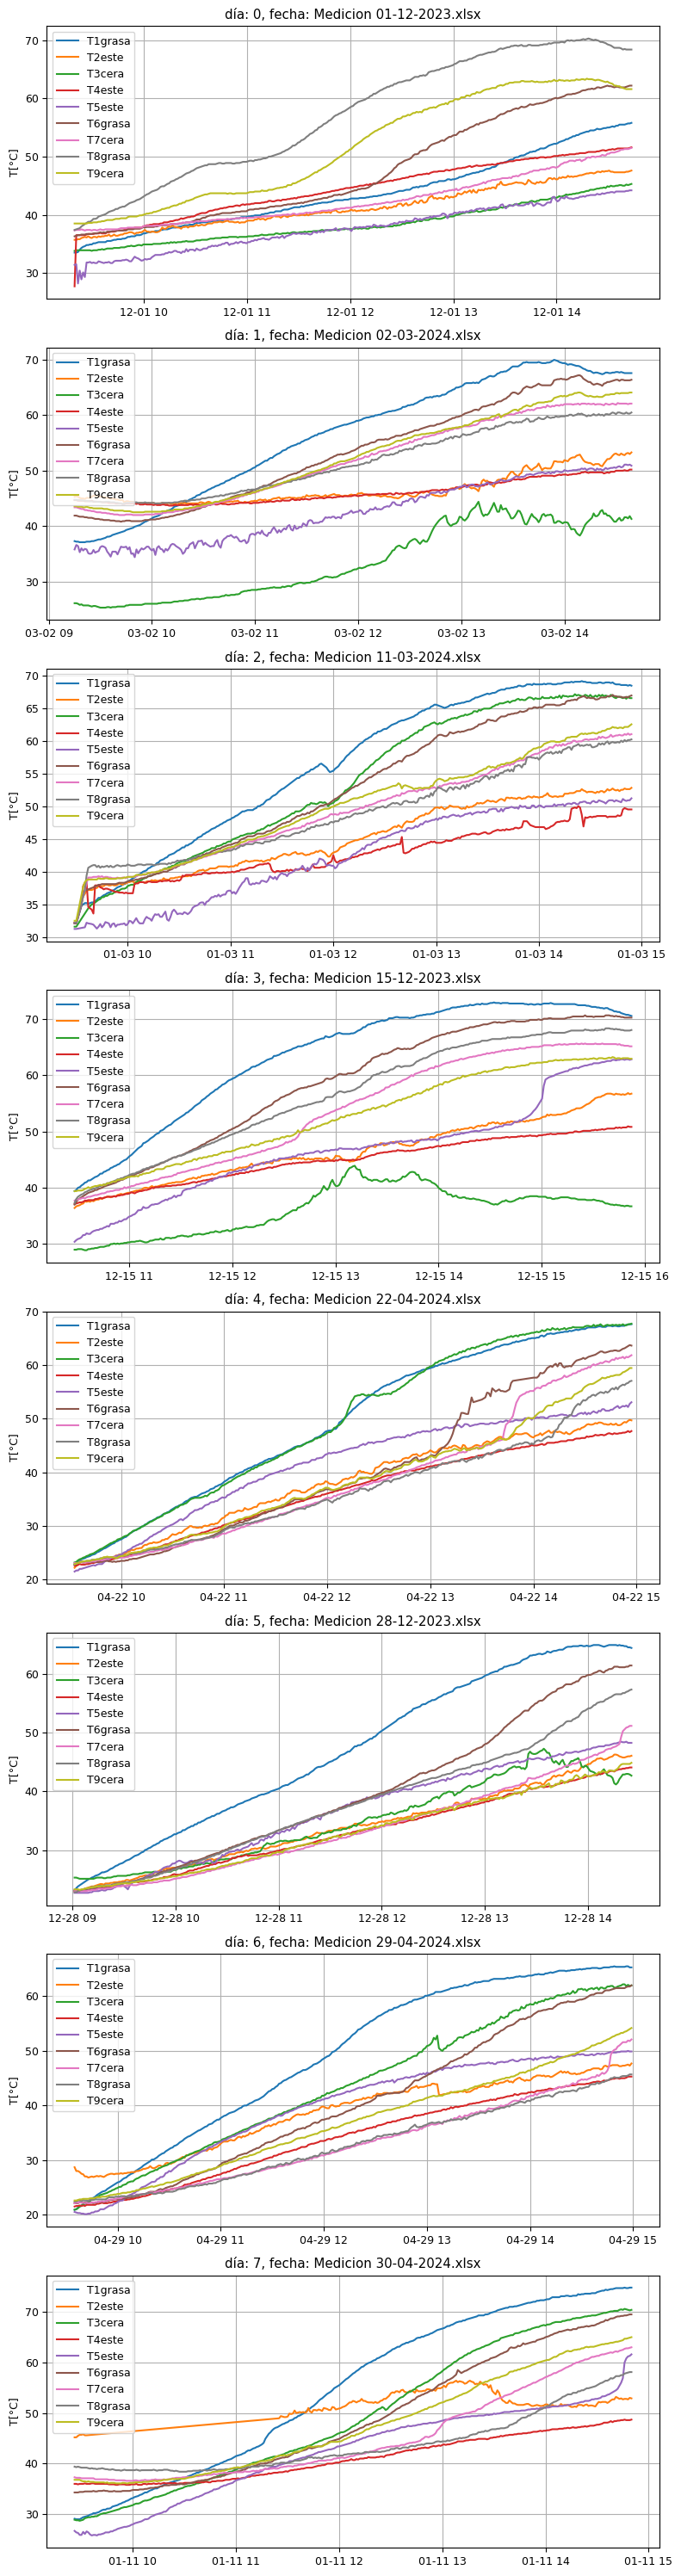

In [5]:
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 9}
plt.rc('font', **font)
df_columns = df_list[0].columns

fig, axs = plt.subplots(len(df_list),1, figsize=(8,30))
for i, df in enumerate(df_list): 
    axs[i].plot(df_date_list[i],df, '-', label = df.columns)
    axs[i].set_title(f"día: {i}, fecha: {files[i]}")
    axs[i].set_ylabel("T[°C]")
    axs[i].legend(loc = 'upper left')
    axs[i].grid()
fig.tight_layout()
plt.show()

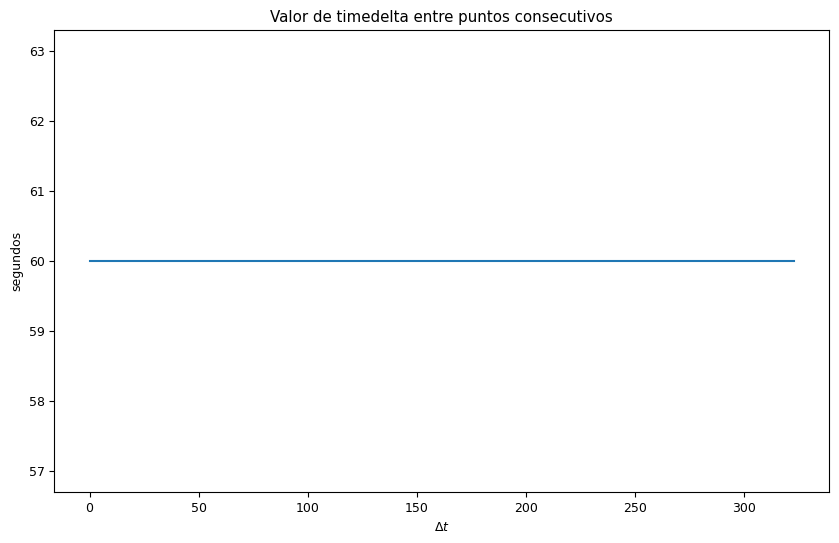

In [11]:
# verificamos que los datos estén completos
dt = np.array(df_date_list[1][1:], dtype = object)-np.array(df_date_list[1][:-1], dtype = object) 
#vector de deltas t. Diferencia del valor anterior con el siguiente.
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_title('Valor de timedelta entre puntos consecutivos')
ax.set_xlabel('$\Delta t$')
ax.set_ylabel('segundos')
ax.plot([d.total_seconds() for d in dt]) 

Viendo la grafiaca, $\Delta t$ vale 60 seg. Es decir, se registra las variables cada una hora. Hay que corregir algunos dias, en los que los $\Delta t$ no son constantes.

## Acondicionando los datos

Como las diferentes series no tienen valores similares, es preciso normalizarlas de alguna manera para que la red neuronal las pese por igual a todas. Para ello vamos a utilizar las herramientas que proporciona Sci-Kit Learn.

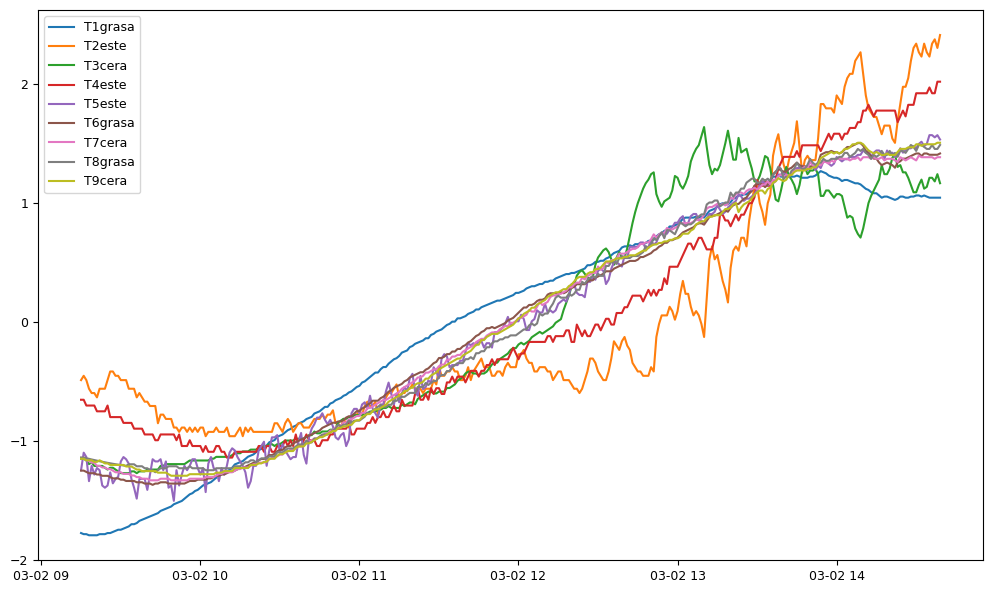

In [16]:
#a todos los datos sacale las medias x' = (x-mu)/sigma
scaler = StandardScaler() 
data = scaler.fit_transform(df_list[1])
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(df_date_list[1], data, label = df_list[1].columns)
ax.legend()
fig.tight_layout()